In [55]:
import h5py
file = "file1001763.h5"
filename = "/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped/singlecoil_val/" + file
hf = h5py.File(filename)
slice = hf['kspace'][()][20]

In [56]:
import matplotlib.pyplot as plt
from fastmri.data.transforms import to_tensor, tensor_to_complex_np
import numpy as np
import torch
def show_coils(data, cmap=None):
    fig = plt.figure()
    plt.imshow(data, cmap=cmap)

torch_slice = to_tensor(slice)

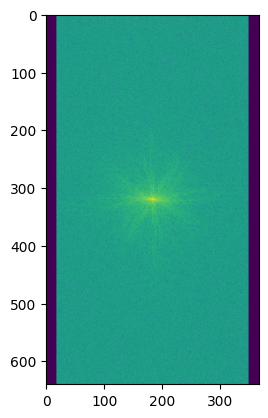

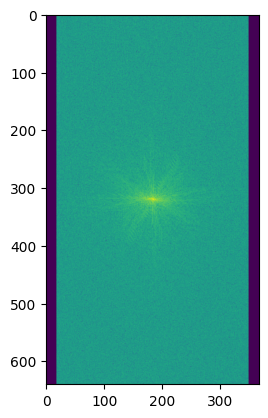

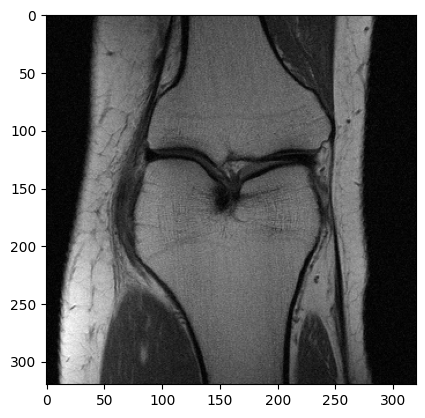

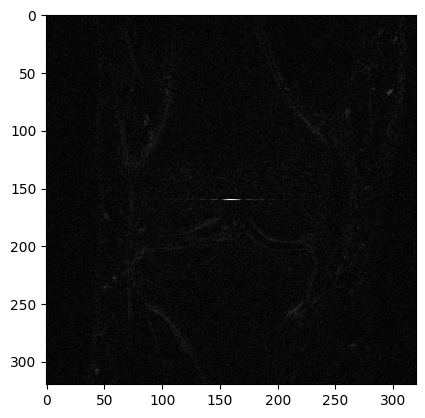

In [62]:
import fastmri.data
import fastmri.data.transforms
import torch
import fastmri

def min_max_normalize(x: torch.Tensor):
    return (x-x.min())/(x.max() - x.min()), torch.stack([x.min(), x.max()], dim=0)

def log_kspace(kspace: torch.Tensor, normalize: bool = True, eps: float = 1e-9):
    magnitude = fastmri.complex_abs(kspace)
    log_magnitude = torch.log(magnitude + eps)  # Apply log transform
    if normalize:
        return min_max_normalize(log_magnitude)
    return log_magnitude

def phase_kspace(kspace: torch.Tensor):
    return torch.atan2(torch_slice[...,0], torch_slice[...,1])

def reconstruct_kspace(magnitude: torch.Tensor, phase: torch.Tensor, log_scale: torch.Tensor = None):
    kspace_rec = magnitude * torch.exp(1j * phase)
    real = kspace_rec.real
    imag = kspace_rec.imag
    return torch.stack([real, imag], dim=-1)

log_slice, log_scale = log_kspace(torch_slice)
phase = phase_kspace(torch_slice)
kspace_processed = torch.stack([log_slice, phase], dim=0)
magnitude = torch.exp(log_slice)

# Reconstruct complex k-space using Euler's formula

from typing import Tuple
kspace_rec = reconstruct_kspace(magnitude, phase)
# Stack to get shape [2, H, W] or [H, W, 2]
new_slice = tensor_to_complex_np(kspace_rec)
show_coils(np.log(np.abs(slice) + 1e-9))
show_coils(np.log(np.abs(new_slice) + 1e-9))
def kspace_to_mri(kspace: torch.Tensor, crop_size: Tuple[int,int] = (320,320)):
    slice_image = fastmri.ifft2c(kspace)
    slice_image_abs = fastmri.complex_abs(slice_image) 
    return fastmri.data.transforms.center_crop(slice_image_abs, crop_size)
show_coils(kspace_to_mri(torch_slice), cmap="gray")
show_coils(kspace_to_mri(kspace_rec), cmap="gray")
